In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from geopandas import sjoin
from shapely.geometry import Point
import scipy
from scipy.spatial import Voronoi

Setting up the Coordinate Reference Systems up front in the necessary format.

In [2]:
# Globals
crs_degree = {'init' :'epsg:3857'}

# Attention: export the geo data (lat/lng and shapefiles) with the same Coordinate Reference System!
### Currently for this IPython (and maybe in future), we are going with `CGS_WGS_1984`.

### How to export:

- In ArcGIS -> Analysis -> Tools: 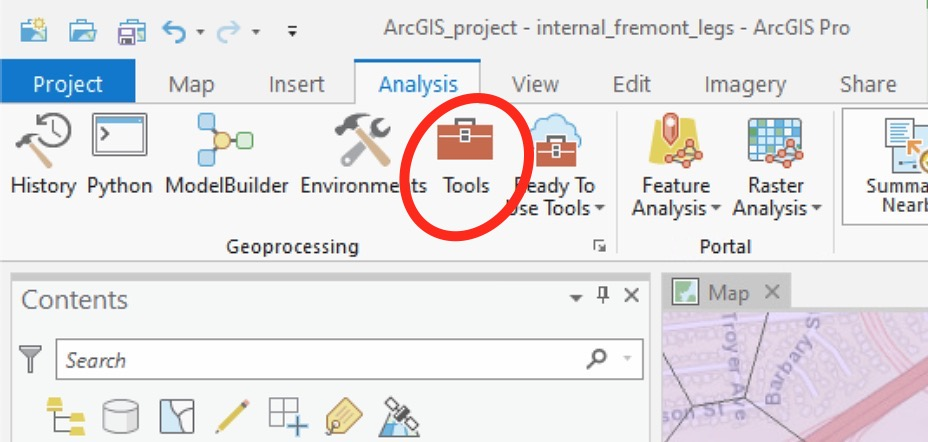

- On the right side, pick the data and click on folder icon: 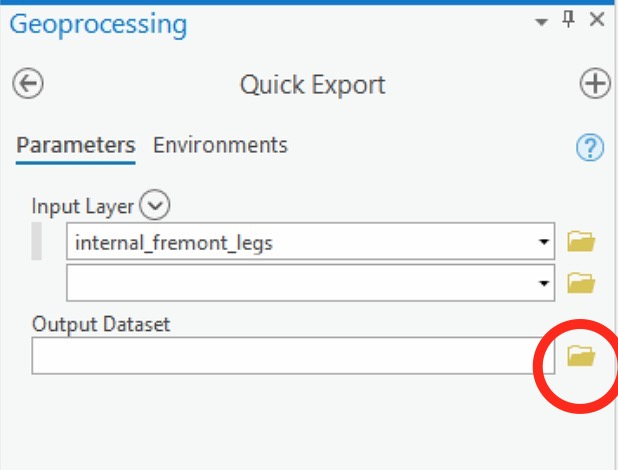

- Pick `CGS_WGS_1984` Coord. system: 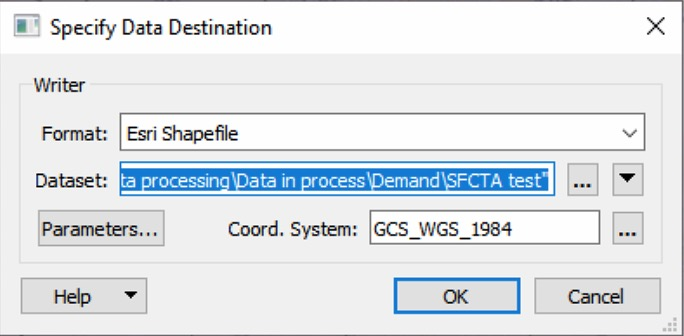


In [3]:
# Paths
data_in_process = "/Users/michaltakac/Dropbox/Data Collection/Data Processing/Data in process"

taz_path = "/Users/michaltakac/Projects/research/usa-ucberkeley/taz/TAZ_to_join_on_the_demand_data"
arcgis_project = "/Users/michaltakac/Dropbox/Data Collection/ArcGIS"
int_centroid_zones = data_in_process + "/Demand/SFCTA test/InternalCentroidZones.shp"

int_legs= "/Users/michaltakac/Dropbox/Data Collection/Raw data/SFCTA demand data/internal_fremont_legs.csv"
start_legs = "/Users/michaltakac/Dropbox/Data Collection/Raw data/SFCTA demand data/starting_fremont_legs.csv"
end_legs = "/Users/michaltakac/Dropbox/Data Collection/Raw data/SFCTA demand data/ending_fremont_legs.csv"

In [4]:
# Load TAZ from shapefile (idk if we're going to use this, it's a bit different than InternalCeontroidZones)
taz = GeoDataFrame.from_file(taz_path + '/Travel Analysis Zones.shp')
taz.head()

,SUPERD,TAZ1454,Shape__Are,Shape__Len,Latitude,Longtitude,geometry
0,18,939,0.0,0.0,37.8148,-122.242,"POLYGON ((566809.615 4185308.338, 566722.763 4..."
1,18,974,0.0,0.0,37.8291,-122.251,"POLYGON ((565582.522 4186840.780, 565485.009 4..."
2,18,914,0.0,0.0,37.8463,-122.215,"POLYGON ((569357.002 4190133.857, 569428.317 4..."
3,18,920,0.0,0.0,37.8133,-122.207,"POLYGON ((570418.897 4185305.157, 570492.068 4..."
4,18,921,0.0,0.0,37.8055,-122.213,"POLYGON ((569570.332 4184676.566, 569658.267 4..."


In [5]:
# Load internal centroid zones from shapefile
icz = GeoDataFrame.from_file(int_centroid_zones)
icz.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,CentroidID,geometry
0,0,2,3732.741316,8.192720e+05,21,"POLYGON Z ((-121.92829 37.49921 0.00000, -121...."
1,1,3,9042.119570,4.329841e+06,26,"POLYGON Z ((-121.95631 37.49854 0.00000, -121...."
2,2,4,6766.028824,2.260875e+06,1,"POLYGON Z ((-121.95809 37.50038 0.00000, -121...."
3,3,5,2672.089121,4.399604e+05,29,"POLYGON Z ((-121.94043 37.50354 0.00000, -121...."
4,4,6,6126.178508,1.361209e+06,25,"POLYGON Z ((-121.93679 37.49704 0.00000, -121...."


In [6]:
int_data = pd.read_csv(int_legs)
start_data = pd.read_csv(start_legs)
end_data = pd.read_csv(end_legs)

# test if loaded...
int_data.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432


In [7]:
# test if loaded...
start_data.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng
0,87531622,2000-01-02 03:27:00 +0800,37.51941,-121.95007,37.59346,-122.38437
1,87585767,2000-01-01 19:38:00 +0800,37.50937,-121.94962,37.50821,-121.96212
2,87585779,2000-01-02 03:07:00 +0800,37.50937,-121.94962,37.60484,-122.38779
3,87588447,2000-01-02 03:01:00 +0800,37.50618,-121.93459,37.58723,-122.47037
4,87600069,2000-01-02 02:11:00 +0800,37.50737,-121.92912,37.58809,-122.37700


In [8]:
# test if loaded...
end_data.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng
0,87531621,2000-01-02 02:18:00 +0800,37.59346,-122.38437,37.51941,-121.95007
1,87574224,2000-01-01 22:02:00 +0800,37.38812,-121.97604,37.53183,-121.92245
2,87585765,2000-01-01 16:32:00 +0800,37.60484,-122.38779,37.50937,-121.94962
3,87585770,2000-01-01 22:19:00 +0800,37.50821,-121.96212,37.50937,-121.94962
4,87581078,2000-01-02 07:05:00 +0800,37.44256,-121.88313,37.50937,-121.94962


In [9]:
# Process XY coordinates data as Point geometry
int_data_geo_points = [Point(xy) for xy in zip(int_data.start_node_lng, int_data.start_node_lat)]

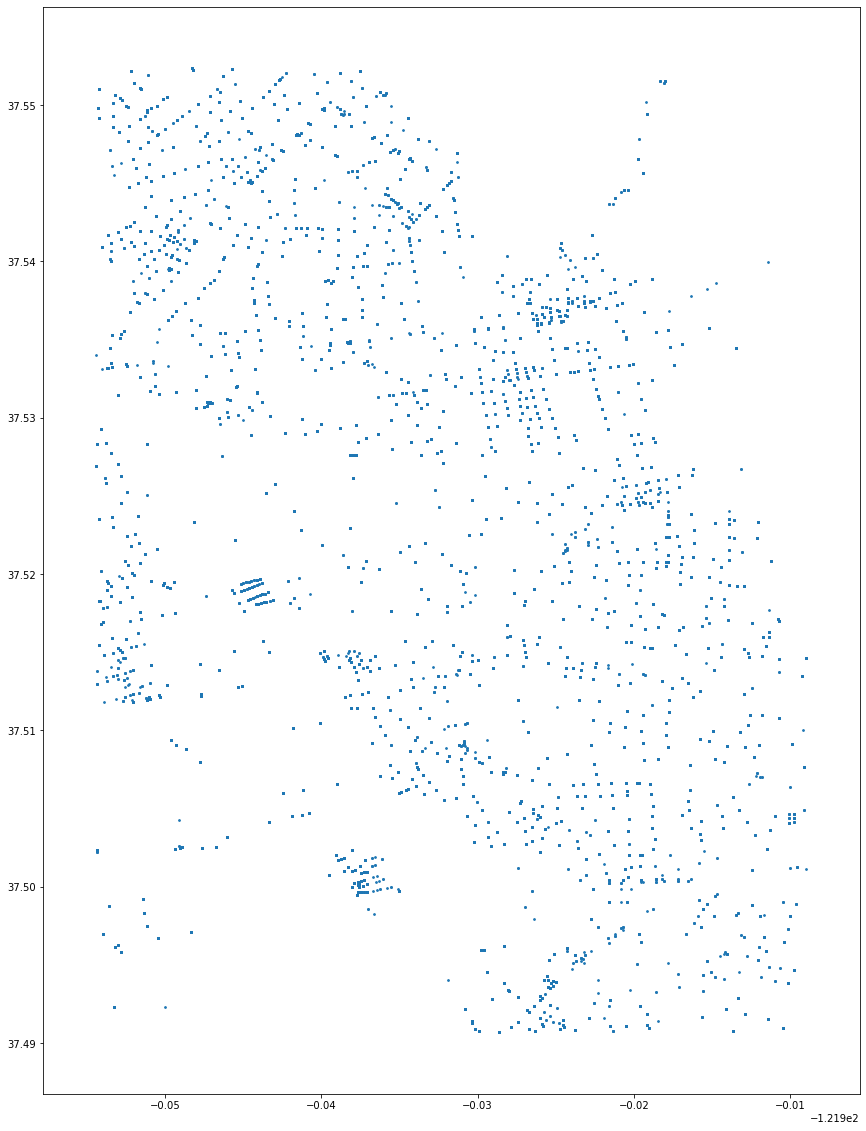

In [10]:
# Visual check - plot points...
GeoPointLocs = GeoDataFrame(int_data, crs={'init': 'epsg:3857'}, geometry=int_data_geo_points)
GeoPointLocs.plot(markersize=3, figsize=(15,20))

In [11]:
# just checking how the GeoDataFrame looks...
GeoPointLocs.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937)
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764)
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287)
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237)
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598)


...okay, so we have geometry as `shapely.Point`s

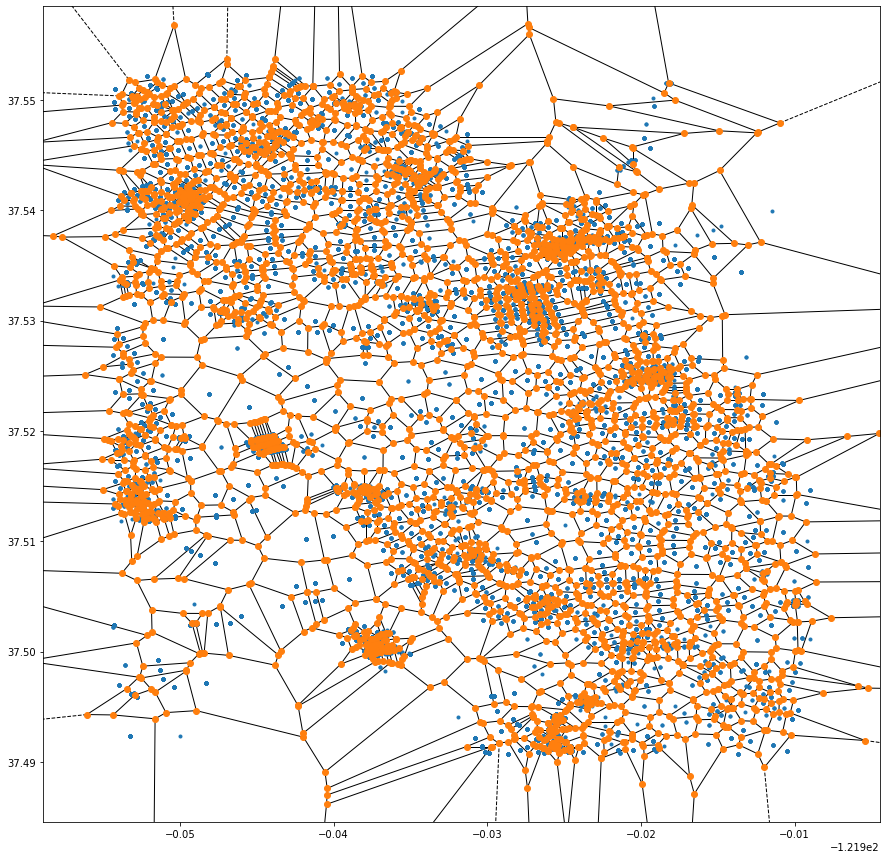

In [12]:
lng_lat_arr = np.array(list(zip(int_data.start_node_lng, int_data.start_node_lat)))
       
# Create Voronoi diagram from array of longitude and latitude coordinates (code from "Spatial Code Primer 2")
vor = Voronoi(lng_lat_arr)
plt.rcParams["figure.figsize"] = [15,15]
scipy.spatial.voronoi_plot_2d(vor)
plt.show()

Here we reuse the code from "Spatial Code Primer 2" (`In [9]`) for defining function that converts Voronoi output to a shapefile (`.shp`):


In [13]:
def voronoi_finite_polygons_2d(vor, radius=None):    
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point. Ridges are the lines between points of the each region polygon
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions. Regions on the outside of the diagram normally extend to infinite - this limits extent
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        print(ridges)
        new_region = [v for v in vertices if v >= 0]
        print(new_region)

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise. Shapefile polygons are drawn in counterclockwise order.
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

### don't use it yet, maybe it won't be needed...

In [14]:
#regions, vertices = voronoi_finite_polygons_2d(vor)
#print(vertices)
#for region in regions:
#    polygon = vertices[region]
    # Clipping polygon
#    poly = Polygon(polygon)
#    poly = poly.intersection(boundary['geometry'][0])
#    polygon = [p for p in poly.exterior.coords]

#    plt.fill(*zip(*polygon), alpha=0.4)

#plt.plot(np.array(list(zip(int_data.start_node_lng, int_data.start_node_lat)))[:, 0], np.array(list(zip(int_data.start_node_lng, int_data.start_node_lat)))[:, 1], 'ko')
#plt.axis('equal')
#plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
#plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
#plt.show()

In [15]:
taz.head()

,SUPERD,TAZ1454,Shape__Are,Shape__Len,Latitude,Longtitude,geometry
0,18,939,0.0,0.0,37.8148,-122.242,"POLYGON ((566809.615 4185308.338, 566722.763 4..."
1,18,974,0.0,0.0,37.8291,-122.251,"POLYGON ((565582.522 4186840.780, 565485.009 4..."
2,18,914,0.0,0.0,37.8463,-122.215,"POLYGON ((569357.002 4190133.857, 569428.317 4..."
3,18,920,0.0,0.0,37.8133,-122.207,"POLYGON ((570418.897 4185305.157, 570492.068 4..."
4,18,921,0.0,0.0,37.8055,-122.213,"POLYGON ((569570.332 4184676.566, 569658.267 4..."


In [16]:
GeoPointLocs.head()

,leg_id,start_time,start_node_lat,start_node_lng,end_node_lat,end_node_lng,geometry
0,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937)
1,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764)
2,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287)
3,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237)
4,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598)


In [17]:
icz.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,CentroidID,geometry
0,0,2,3732.741316,8.192720e+05,21,"POLYGON Z ((-121.92829 37.49921 0.00000, -121...."
1,1,3,9042.119570,4.329841e+06,26,"POLYGON Z ((-121.95631 37.49854 0.00000, -121...."
2,2,4,6766.028824,2.260875e+06,1,"POLYGON Z ((-121.95809 37.50038 0.00000, -121...."
3,3,5,2672.089121,4.399604e+05,29,"POLYGON Z ((-121.94043 37.50354 0.00000, -121...."
4,4,6,6126.178508,1.361209e+06,25,"POLYGON Z ((-121.93679 37.49704 0.00000, -121...."


In [18]:
# Load internal fremont legs from shapefile
int_legs = GeoDataFrame.from_file(data_in_process + '/Demand/SFCTA test/internal_fremont_legs.shp')
int_legs.head()

,OBJECTID,leg_id,start_time,start_node,start_no00,end_node_l,end_node00,geometry
0,1,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937)
1,2,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764)
2,3,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287)
3,4,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237)
4,5,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598)


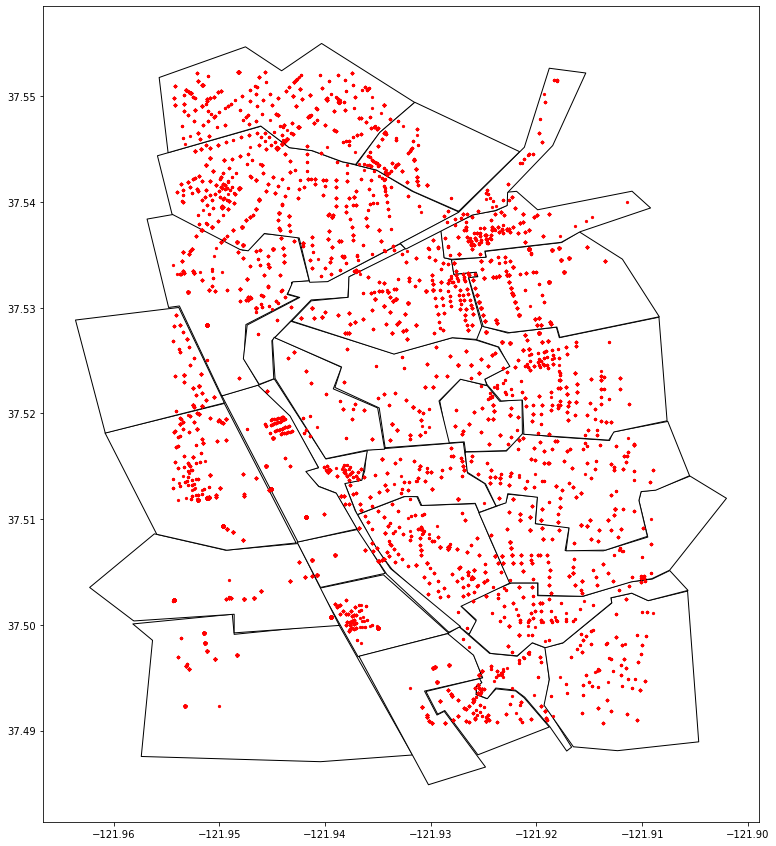

In [19]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

icz.plot(ax=ax, color='white', edgecolor='black')
GeoPointLocs.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show();

In [21]:
# Spatial join
# docs: http://geopandas.org/mergingdata.html
int_int_OD = gpd.sjoin(int_legs, icz, how='left', op='intersects')
int_int_OD.head()

,OBJECTID_left,leg_id,start_time,start_node,start_no00,end_node_l,end_node00,geometry,index_right,FID,OBJECTID_right,Shape_Leng,Shape_Area,CentroidID
0,1,87585773,2000-01-01 22:39:00 +0800,37.50937,-121.94962,37.50078,-121.93948,POINT (-121.94962 37.50937),16,16,18,6270.634124,2.379123e+06,2
1,2,87663883,2000-01-01 22:52:00 +0800,37.51764,-121.94493,37.51287,-121.94508,POINT (-121.94493 37.51764),15,15,17,5539.626488,1.167626e+06,30
2,3,87663885,2000-01-02 00:29:00 +0800,37.51287,-121.94508,37.51764,-121.94493,POINT (-121.94508 37.51287),15,15,17,5539.626488,1.167626e+06,30
3,4,87771074,2000-01-01 22:35:00 +0800,37.50237,-121.95432,37.49598,-121.92959,POINT (-121.95432 37.50237),2,2,4,6766.028824,2.260875e+06,1
4,5,87771078,2000-01-02 02:48:00 +0800,37.49598,-121.92959,37.50237,-121.95432,POINT (-121.92959 37.49598),4,4,6,6126.178508,1.361209e+06,25
